<a href="https://colab.research.google.com/github/lzylili/variational-quantum-eigensolver/blob/master/VQE_H2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Variational Quantum Eigensolver for H2 Molecule
The **Variational Quantum Eigensolver (VQE)** is a hybrid quantum-classical algorithm that finds the smallest eigenvalue (and corresponding eigenvector) of a given Hamiltonian. For our purposes, we'll be applying this algorithm to a chemistry problem, wherein we need to be find the ground energy state of a H2 molecule. *One of its most promising applications lie in quantum chemistry.*  

When we scale the complexity of the chemistry problem (and scale the number of qubits we're using), we can apply this algorithm to problems in drug discovery and computatonal biology like protein folding and molecular docking. Of course, the algorithm would be exponentially more complex. This would mean that our hardware also needs to scale (and we're not there yet). Nonetheless, *this is still an extremely exciting field in quantum computing, so here goes!*


Before we start, make sure to install the necessary libraries / packages (we'll be using IBM's Qiskit platform for most of the functions and the PyQuante driver, which can be cloned from its github repository).

In [8]:
!pip install qiskit
!git clone https://github.com/rpmuller/pyquante2.git

**Step 1**: import all the necessary repositories from qiskit aqua and chemistry.

In [0]:
import numpy as np
import pylab
import copy
from qiskit import BasicAer
from qiskit.aqua import aqua_globals, QuantumInstance
from qiskit.aqua.algorithms import ExactEigensolver, VQE
from qiskit.aqua.components.optimizers import COBYLA
from qiskit.chemistry.aqua_extensions.components.initial_states import HartreeFock
from qiskit.chemistry.aqua_extensions.components.variational_forms import UCCSD
from qiskit.chemistry.drivers import PySCFDriver
from qiskit.chemistry.core import Hamiltonian, QubitMappingType

**Step 2**: Define the molecule and configure the interatomic distance (starting point and range) 

In [0]:
molecule = 'H .0 .0 -{0}; H .0 .0 {0}'
algorithms = ['VQE', 'ExactEigensolver']

start = 0.5  # Start distance
by    = 0.5  # How much to increase distance by
steps = 23   # Number of steps to increase by
energies = np.empty([len(algorithms), steps+1])
hf_energies = np.empty(steps+1)
distances = np.empty(steps+1)
eval_counts = np.empty(steps+1)

**Step 3**: Define the VQE algorithm (we'll want to use the exact eigensolver too in order to compare the accuracy of the VQE with) and run it on IBM's backend simulator. Print the calculated results. 

In [31]:
print('Processing step __', end='')
for i in range(steps+1):
    print('\b\b{:2d}'.format(i), end='', flush=True)
    d = start + i*by/steps 

    # set a loop to run the algorithm as many times as necessary to go through all the iterations (in interatomic distance) specified in step 1
    for j in range(len(algorithms)):
        driver = PySCFDriver(molecule.format(d/2), basis='sto3g')
        qmolecule = driver.run()
        operator =  Hamiltonian(qubit_mapping=QubitMappingType.JORDAN_WIGNER,
                                two_qubit_reduction=False)
        qubit_op, aux_ops = operator.run(qmolecule)
        
        # run the exact eigensolver in order to create a benchmark to compare VQE values with at the end of the experiment
        if algorithms[j] == 'ExactEigensolver':
            result = ExactEigensolver(qubit_op).run()
        else: #otherwise, run the VQE (has 3 components: the optimizer, the initial state, and the variational form)
            optimizer = COBYLA(maxiter=10000)
            initial_state = HartreeFock(qubit_op.num_qubits,
                                        operator.molecule_info['num_orbitals'],
                                        operator.molecule_info['num_particles'],
                                        qubit_mapping=operator._qubit_mapping,
                                        two_qubit_reduction=operator._two_qubit_reduction)
            var_form = UCCSD(qubit_op.num_qubits, depth=1,
                            num_orbitals=operator.molecule_info['num_orbitals'],
                            num_particles=operator.molecule_info['num_particles'],
                            initial_state=initial_state,
                            qubit_mapping=operator._qubit_mapping,
                            two_qubit_reduction=operator._two_qubit_reduction)
            algo = VQE(qubit_op, var_form, optimizer)

            # initialize and run on backend quantum simulator and store the calculated values in variable 'result'
            result = algo.run(QuantumInstance(BasicAer.get_backend('statevector_simulator'))) 

        # define the variables for our results and print them
        lines, result = operator.process_algorithm_result(result)
        energies[j][i] = result['energy']
        hf_energies[i] = result['hf_energy']
        if algorithms[j] == 'VQE':
            eval_counts[i] = result['algorithm_retvals']['eval_count']
    distances[i] = d
print(' --- complete')

print('Distances: ', distances) #interatmomic distance
print('Energies:', energies) # ground state energy calculated by the exact eigensolver and the VQE
print('Hartree-Fock energies:', hf_energies) # energies calculated by the Hartree Fock algorithm
print('VQE num evaluations:', eval_counts)

Processing step __ 0 1 2 3 4 5 6 7 8 91011121314151617181920212223 --- complete
Distances:  [0.5        0.52173913 0.54347826 0.56521739 0.58695652 0.60869565
 0.63043478 0.65217391 0.67391304 0.69565217 0.7173913  0.73913043
 0.76086957 0.7826087  0.80434783 0.82608696 0.84782609 0.86956522
 0.89130435 0.91304348 0.93478261 0.95652174 0.97826087 1.        ]
Energies: [[-1.05515977 -1.07344995 -1.08862234 -1.10109216 -1.11121301 -1.11928813
  -1.12557945 -1.13031403 -1.13368986 -1.13588003 -1.13703598 -1.13729068
  -1.13676067 -1.13554825 -1.13374316 -1.13142414 -1.12866032 -1.12551235
  -1.12203364 -1.11827121 -1.11426669 -1.11005699 -1.10567502 -1.10115032]
 [-1.05515979 -1.07344997 -1.08862236 -1.10109218 -1.11121303 -1.11928818
  -1.12557946 -1.13031404 -1.13368989 -1.13588003 -1.13703601 -1.13729069
  -1.13676068 -1.13554825 -1.13374316 -1.13142415 -1.12866032 -1.12551236
  -1.12203365 -1.11827123 -1.1142667  -1.11005699 -1.10567503 

**Step 4**: Graph out the results using pylab (note: we can't see the line for VQE because it overlaps with the line for the exact eigensolver)

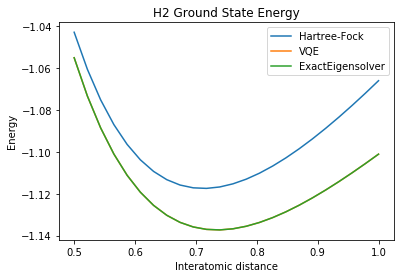

In [32]:
# graph for all calculated values

pylab.plot(distances, hf_energies, label='Hartree-Fock')
for j in range(len(algorithms)):
    pylab.plot(distances, energies[j], label=algorithms[j])
pylab.xlabel('Interatomic distance')
pylab.ylabel('Energy')
pylab.title('H2 Ground State Energy')
pylab.legend(loc='upper right');

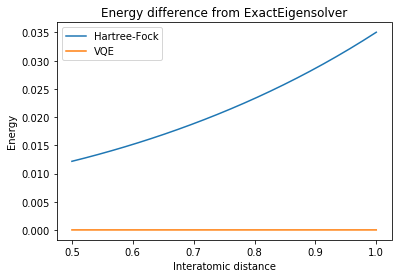

In [33]:
# graph comparing the difference between calculated values from the exact eigensolver and the 2 other algorithms

pylab.plot(distances, np.subtract(hf_energies, energies[1]), label='Hartree-Fock')
pylab.plot(distances, np.subtract(energies[0], energies[1]), label='VQE')
pylab.xlabel('Interatomic distance')
pylab.ylabel('Energy')
pylab.title('Energy difference from ExactEigensolver')
pylab.legend(loc='upper left');

**And that's it!** Visit IBM's Qiskit community tutorials for more examples of VQEs applied for different molecules!

Link: https://github.com/Qiskit/qiskit-community-tutorials/blob/master/chemistry